In [1]:
### 주피터노트북 이미지 확인용 함수

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [2]:
import pytesseract
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours

pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'
config = ('-l kor+eng --oem 3 --psm 4') 
test_img="/Users/kjh001/Desktop/study/ai_study/eggo_test.png"

img=cv2.imread(test_img)
# cv2.imshow("ori",img) #이미지 띄우기

def gray_scale(image):
    # img_gray=cv2.cvtColor(img, cv2.COLOR_BAYER_BG2GRAY) // 왜 오류나는지 모르겠음
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresholding(image): # 이미지 임계처리 (이진화)
    # threshold(src,thresh,maxval,type) //thresh:임계값, maxval:임계값을 넘었을 때 적용할 value, type:thresholding type
    # thresholding type: cv2.THRESH_BINARY/cv2.THRESH_BINARY_INV/cv2.THRESH_TRUN/,cv2.THRESH_TOZERO/cv2.THRESH_TOZERO_INV
    result=cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return result

def remove_noise(image): # 노이즈제거 (커널 사이즈는 홀수로)
    return cv2.medianBlur(image,5)

# Erode - Dilate = Opening 연산: 주로 작은 노이즈 제거
# Dilate - Erode = Closing 연산: 한 객체 추출했을 때 두 개 이상의 작은 부분으로 나올 경우 큰 객체로 합칠 때 사용
def dilate(image): # 필터 내부의 가장 밝은(높은) 값으로 변환(or)
    kernel= np.ones((5,5),np.uint8)
    return cv2.dilate(image,kernel, iterations=1)

def erode(image): # 필터 내부의 가장 낮은(어두운) 값으로 변환(and)
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations=1)

# morphologyEx: opening, closing 수행 함수
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel)

def canny(image): # 이미지 엣지 리턴
    return cv2.Canny(image,100,200) # 숫자 작게할수록 자세히

def deskew(image): # 숫자 이미지를 읽어 기울어진 이미지 보정
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)    
    return rotated

# def match_template(image, template): # 이미지에서 템플릿과 일치하는 부분 찾음
#     return cv2.matchTemplate(image,template, cv2.TM_CCOEFF_NORMED)

def filter2D(image): # 이미지 선명하게
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(image, 0, kernel)

deskew = deskew(img)
gray = gray_scale(deskew)

print(img.shape)

(1336, 916, 3)


# 이미지 속 텍스트 인식 구현

In [3]:
### 이미지 내 관심영역 추출과 텍스트 추출

# x,y 반대로
x_indivi=770; y_indivi=20; w_indivi=450; h_indivi=340    # roi 좌표(개별관리비)
x_date=480; y_date=450; w_date=220; h_date=270     # roi 좌표(날짜 정보)
x_price=480; y_price=670; w_price=230; h_price=270     # roi 좌표(이번 달 총금액)


roi1 = gray[x_indivi:x_indivi+h_indivi , y_indivi:y_indivi+w_indivi]  # roi 지정
roi2 = gray[x_date:x_date+h_date , y_date:y_date+w_date]  # roi 지정
roi3 = gray[x_price:x_price+h_price, y_price:y_price+w_price]  # roi 지정

cv2.rectangle(roi1, (0,0), (w_indivi-1, h_indivi-1), (0,0,255) ,2) # roi 전체에 사각형 그리기
cv2.rectangle(roi2, (0,0), (w_date-1, h_date-1), (0,0,255) ,2) # roi 전체에 사각형 그리기
cv2.rectangle(roi3, (0,0), (w_price-1, h_price-1), (0,0,255) ,2) # roi 전체에 사각형 그리기

text_indivi=pytesseract.image_to_string(roi1,config=config)
text_date=pytesseract.image_to_string(roi2,config=config)
text_price=pytesseract.image_to_string(roi3,config=config)


## 확인용

print("-----개별관리비-----")
print(text_indivi)
print("-----날짜정보-----")
print(text_date)
print("-----총금액-----")
print(text_price)

# cv2.imshow("image", gray)
# key = cv2.waitKey(0)
# print(key)
# cv2.destroyAllWindows()

-----개별관리비-----
공용소계         91,590     91,910     -320

전기 331 kw        41,280    40,610    670
Weae           2,500      2,500
케이블 TV          4,400      4,400
주차비
수도 23 03           25,740      23,050    2,690
일자리청소차         -140      -140        {
일자리경비차         -200      -340 140
관리비 과남

AWA        73,580 70,080 3,500


-----날짜정보-----
2022년 02일분

112동 306호
기2코드 4060-161
[BRAS — 0112-0306-8
월분 2022-02

데카드 자동이체 *
삼각

-----총금액-----
: 남입수증 Ea)

165,170

그린타운 판리사무소 귀중



# 인식된 텍스트 정리

In [11]:
### 날짜 정보
start_date=text_date.find('월분')+2
date_l=text_date[start_date:start_date+10].strip().split("-")
date_this=date_l[0]+date_l[1]
### 전기
start_use_e = text_indivi.find('전기')+2
elec_use = text_indivi[start_use_e:start_use_e+4].strip()
start_price_e = text_indivi.find('kw')+2
elec_price = text_indivi[start_price_e:start_price_e+18].strip()
### 수도
start_use_w = text_indivi.find('수도')+2
wat_use = text_indivi[start_use_w:start_use_w+3].strip()
start_price_w = text_indivi.find('수도')+15
wat_price = text_indivi[start_price_w:start_price_w+15].strip()
### 총금액 --> !!위치로 따온거라 수정해야 할수도 있음!!
splits=text_price.splitlines()
price_this=splits[2]

print("날짜 정보(yyyymm): ", date_this,'\n')
print("이번 달 전기 사용량:",elec_use,"kw")
print("이번 달 전기 요금:",elec_price,"원",'\n')
print("이번 달 수도 사용량:",wat_use,"m3")
print("이번 달 수도 요금:",wat_price,"원",'\n')
print("이번 달 총 요금:", price_this,"원")

날짜 정보(yyyymm):  202202 

이번 달 전기 사용량: 331 kw
이번 달 전기 요금: 41,280 원 

이번 달 수도 사용량: 23 m3
이번 달 수도 요금: 25,740 원 

이번 달 총 요금: 165,170 원


# 사용자 데이터를 이용한 에너지 소비량 예측 구현

예측 전기 소비량 [328.71410555]
예측 수도 소비량 [30.29263457]
rbf 결정계수 R:  0.7834005507267277
rbf 결정계수 R:  0.687947201631383


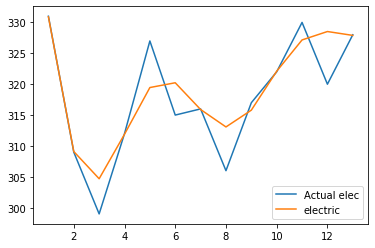

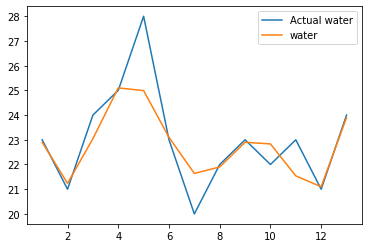

In [17]:
### 다음 달 금액 예측하기 (테스트용 데이터)

from sklearn.svm import SVR
import pandas as pd
from pandas_datareader import data as pdr

# 고지서에서 읽은 사용자의 사용량 데이터라고 가정
test_data_elec=[331,309,299,312,327,315,316,306,317,322,330,320,328]
test_data_wat=[23,21,24,25,28,23,20,22,23,22,23,21,24]

months=[]

j=1

for j in range(len(test_data_elec)):
    months.append([int(j+1)])
    j=j+1
    
# linear svr, polynomial svr, rbf svr 적용 

# # 선형회귀; 
# lin_svr = SVR(kernel='linear', C=1000)
# lin_svr.fit(months,test_data_elec)
# # 다항회귀; 비선형 데이터를 학습하기 위해 선형모델 사용, 각 변수의 거듭 제곱을 새로운 변수로 추가하고 확장된 변수를 포함한 데이터셋에 선형모델을 훈련시킴
# poly_svr = SVR(kernel='poly', C=1000, degree=2)
# poly_svr.fit(months,test_data_elec)

# RBF 회귀; gamma 파라미터는 C파라미터와 비슷, gamma값이 크면 training 데이터에 더 많은 중요도 부여해 overfitting될 수 있고 값이 작으면 underfitting될 수 있음.
rbf_svr_e1 = SVR(kernel='rbf', C=1000, gamma=0.05)
rbf_svr_w1 = SVR(kernel='rbf', C=1000, gamma=0.05)

rbf_svr_e1.fit(months,test_data_elec)
rbf_svr_w1.fit(months,test_data_wat)


### 다음 달 전기 사용량 예측
# SVR: regression에 사용되는 SVM모델

nextMonth = [[len(months)+1]]

print('예측 전기 소비량', rbf_svr_e1.predict(nextMonth))
print('예측 수도 소비량', rbf_svr_w1.predict(nextMonth))

print("rbf 결정계수 R: ", rbf_svr_e1.score(months, test_data_elec))
print("rbf 결정계수 R: ", rbf_svr_w1.score(months, test_data_wat))


### SVR 세가지 회귀모델 학습 시각화
plt.plot(months, test_data_elec,label='Actual elec')
plt.plot(months, rbf_svr_e1.predict(months),label='electric')
plt.legend()
plt.show()

plt.plot(months, test_data_wat,label='Actual water')
plt.plot(months, rbf_svr_w1.predict(months),label='water')
plt.legend()
plt.show()

